In [1]:
#text clustering
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
df = pd.read_csv('/content/drive/My Drive/edited_cut_edu_little.csv')
df.head()

,Unnamed: 0,id,topic,heading,summary,date,sub,content,tag,processed_topic,processed_content
0,0,5ef0d321d83b3587cb500efc,"[""football""]","[""VAR not being used correctly: Barcelona coac...","[""Barcelona had a goal ruled out by VAR for of...","[""Updated: Jun 22, 2020 20:03 IST""]","[""Reuters""]","[""The Video Assistant Referee (VAR) system is ...","[""Quique Setien"",""Barcelona""]",footbal,video assist refere correct liga barcelona man...
1,1,5ef0d324d83b3587cb500efd,"[""football""]","[""Mourinho hits back at Mersonâ€™s criticism o...","[""Merson, a pundit with Sky Sports, said 26-ye...","[""Updated: Jun 22, 2020 20:30 IST""]","[""Reuters""]","[""Jose Mourinho launched an impassioned defenc...","[""Jose Mourinho"",""Harry Kane"",""Manchester unit...",footbal,jose mourinho launch impass defenc harri kaneâ...
2,2,5efff14f86936ae10d2be3c8,"[""football""]","[""Morata double leads Atletico to 3-0 win over...","[""Morata earned a penalty when he was pulled d...","[""Updated: Jul 04, 2020 07:12 IST""]","[""Associated Press""]","[""Alvaro Morata scored twice to lead Atletico ...","[""Alvaro Morata"",""Mallorca"",""Diego Simeone"",""R...",footbal,alvaro morata score twice lead atletico madrid...
3,3,5efff10a86936ae10d2be3aa,"[""cricket""]","[""Sourav Ganguly made Sehwag open, brought in ...","[""Former India opener Wasim Jaffer, who made h...","[""Updated: Jul 04, 2020 08:03 IST""]","[""hindustantimes.com""]","[""Despite not being able to lead India to an I...","[""Sourav Ganguly"",""Wasim Jaffer"",""India"",""Zahe...",cricket,despit abl lead india trophi sole india joint ...
4,4,5ef0d2e5d83b3587cb500edf,"[""cricket""]","[""Jasprit Bumrah is â€˜a different beastâ€™ wh...","[""The man in charge of the team currently is h...","[""Updated: Jun 22, 2020 20:57 IST""]","[""hindustantimes.com""]","[""Mumbai Indians are the most successful team ...","[""Mumbai Indians"",""Jasprit Bumrah"",""Mahela Jay...",cricket,mumbai indian success team histori indian prem...


In [5]:
df.shape

(14, 11)

In [6]:
#feature extraction
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.processed_content.values)
features = vec.transform(df.processed_content.values)

In [7]:
#model training
random_state = 0
cls = MiniBatchKMeans(n_clusters=3, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [8]:
#predict on new data
cls.predict(features)

array([2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

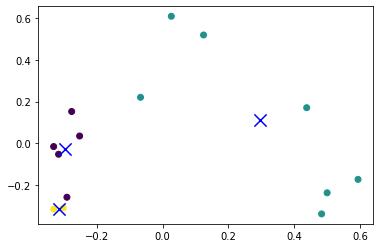

In [9]:
#visualization
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [ ]:
#evaluation with labelled dataset
from sklearn.metrics import homogeneity_score
homogeneity_score(df.heading, cls.predict(features))

0.37599864304472536

In [ ]:

#evaluation with unlabelled dataset
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.05049869227737168

In [ ]:
#more on accuracy scores

#actual labels
actual_labels = np.unique(df.processed_topic, return_inverse=True)[1]
#pd.factorize(df.processed_topic)[0]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(cls.labels_, actual_labels)

0.9285714285714286

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(30.5, 0.5, 'predicted label')

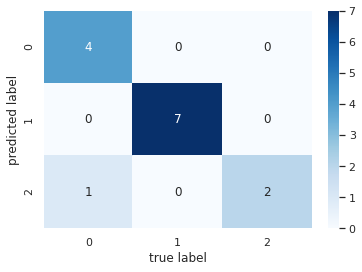

In [ ]:
import seaborn as sns
sns.set()
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(cls.labels_, actual_labels)
sns.heatmap(mat.T, annot=True, fmt='d', cmap = 'Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
from sklearn.metrics import classification_report
classification_report(actual_labels, cls.labels_) 

'              precision    recall  f1-score   support\n\n           0       0.80      1.00      0.89         4\n           1       1.00      1.00      1.00         7\n           2       1.00      0.67      0.80         3\n\n    accuracy                           0.93        14\n   macro avg       0.93      0.89      0.90        14\nweighted avg       0.94      0.93      0.93        14\n'

In [ ]:
from sklearn.metrics import precision_score
precision_score(actual_labels, cls.labels_,  average='micro')

0.9285714285714286

In [ ]:
from sklearn.metrics import recall_score
recall_score(actual_labels, cls.labels_, average='micro')

0.9285714285714286

In [ ]:
cls.labels_

array([2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
actual_labels

array([2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [10]:
#hierarchial clustering

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(reduced_features, 'ward')

In [11]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(reduced_features))
c
# close to 1 better the results

0.8960011935153521

In [12]:
Z[1]

array([3.        , 4.        , 0.03977114, 2.        ])

In [13]:
Z[0]

array([0.        , 2.        , 0.02879521, 2.        ])

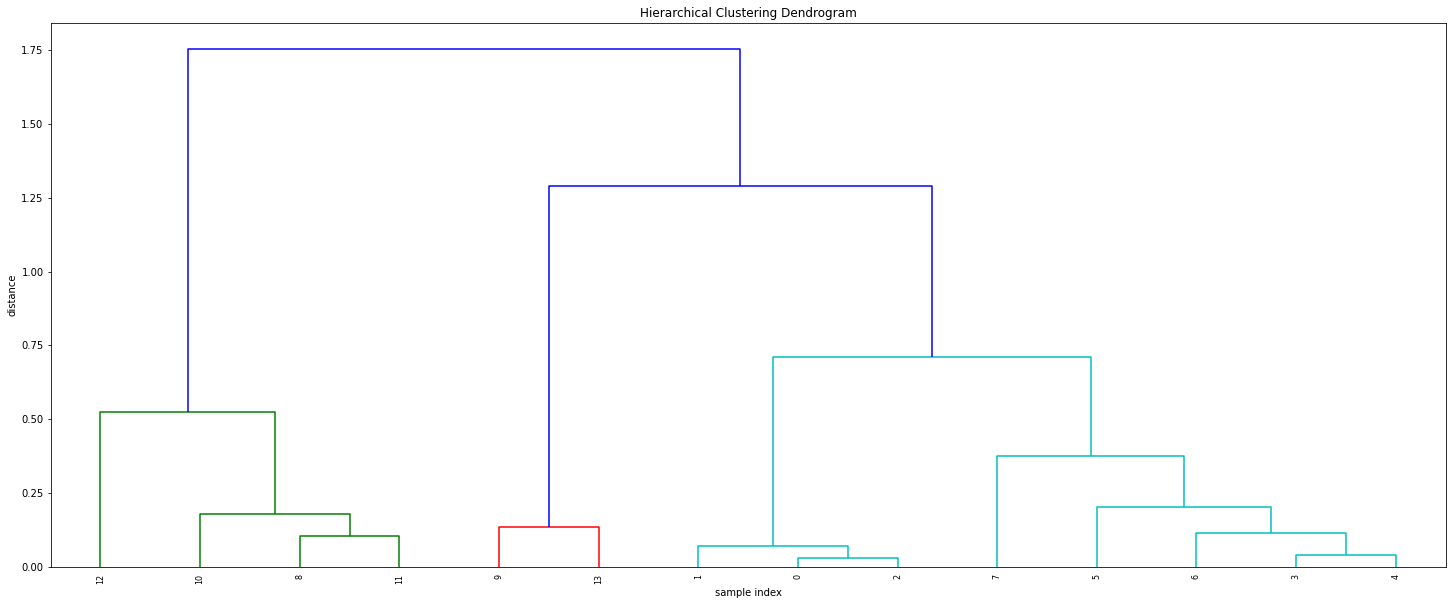

In [14]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

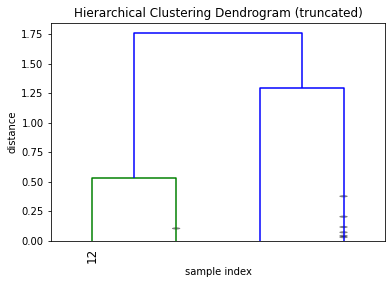

In [21]:
#Dendrogram Truncation

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='level',  # show only the last p merged clusters
    p=1,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

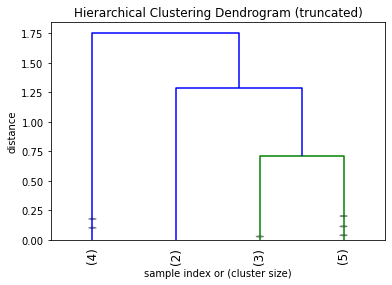

In [16]:
#As it's kind of hard to keep track of the cluster sizes just by the dots, dendrogram() will by default also print the cluster sizes in brackets () if a cluster was truncated

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=4,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

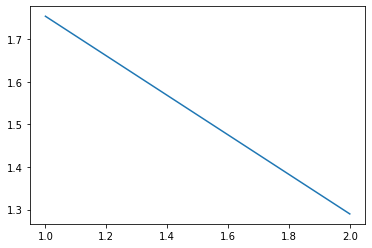

In [17]:
#Elbow Method

#It tries to find the clustering step where the acceleration of distance growth is the biggest (the "strongest elbow" of the blue line graph below, which is the highest value of the green graph below)

last = Z[-2:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()


#k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
#print ("clusters:", k)

In [ ]:
#topic modelling
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

random_state = 0

def only_nouns(texts):
    output = []
    for doc in nlp.pipe(texts):
        noun_text = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(noun_text)
    return output


df['noun_content'] = only_nouns(df['content'])

df.head()

,id,topic,heading,summary,date,sub,content,tag,processed_content,noun_content
0,5ef0d321d83b3587cb500efc,"[""football""]","[""VAR not being used correctly: Barcelona coac...","[""Barcelona had a goal ruled out by VAR for of...","[""Updated: Jun 22, 2020 20:03 IST""]","[""Reuters""]","[""The Video Assistant Referee (VAR) system is ...","[""Quique Setien"",""Barcelona""]",video assist refere correct liga barcelona man...,"var system manager win "",""madrid top home side..."
1,5ef0d324d83b3587cb500efd,"[""football""]","[""Mourinho hits back at Mersonâ€™s criticism o...","[""Merson, a pundit with Sky Sports, said 26-ye...","[""Updated: Jun 22, 2020 20:30 IST""]","[""Reuters""]","[""Jose Mourinho launched an impassioned defenc...","[""Jose Mourinho"",""Harry Kane"",""Manchester unit...",jose mourinho launch impass defenc harri kaneâ...,defence form playing style television pundit s...
2,5efff14f86936ae10d2be3c8,"[""football""]","[""Morata double leads Atletico to 3-0 win over...","[""Morata earned a penalty when he was pulled d...","[""Updated: Jul 04, 2020 07:12 IST""]","[""Associated Press""]","[""Alvaro Morata scored twice to lead Atletico ...","[""Alvaro Morata"",""Mallorca"",""Diego Simeone"",""R...",alvaro morata score twice lead atletico madrid...,win finish league team title race leader point...
3,5efff10a86936ae10d2be3aa,"[""cricket""]","[""Sourav Ganguly made Sehwag open, brought in ...","[""Former India opener Wasim Jaffer, who made h...","[""Updated: Jul 04, 2020 08:03 IST""]","[""hindustantimes.com""]","[""Despite not being able to lead India to an I...","[""Sourav Ganguly"",""Wasim Jaffer"",""India"",""Zahe...",despit abl lead india trophi sole india joint ...,trophy winner captain number captain test cric...
4,5ef0d2e5d83b3587cb500edf,"[""cricket""]","[""Jasprit Bumrah is â€˜a different beastâ€™ wh...","[""The man in charge of the team currently is h...","[""Updated: Jun 22, 2020 20:57 IST""]","[""hindustantimes.com""]","[""Mumbai Indians are the most successful team ...","[""Mumbai Indians"",""Jasprit Bumrah"",""Mahela Jay...",mumbai indian success team histori indian prem...,team history team title cliffhanger season vic...


In [ ]:
# change this to see different results using the components_ attribute
n_topics = 3

#for extracting features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
features = vec.fit_transform(df.noun_content)

#for topic modelling

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=3, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
# list of unique words found by the vectorizer
feature_names = vec.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 15

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 result exam student class board assessment 10th examination lakh mark school credential paper year release 
1 test team player match game captain goal head league field coach people title series cricket 
2 school government parent lockdown class state student court order people decision minister country pandemic lot 


In [ ]:
# to identify topic of a new document
new_articles = [
    '''I have arranged for a loudspeaker system on a cart. The teachers are asked to turn-wise go with the cart and park it at a feasible location and impart lessons from there. It cannot match up to classroom learning but will ensure some learning,” he said. This strange new way of educating school students is not uncommon in the country’s rural parts. The lockdown induced by COVID-19 in March prompted schools and colleges to move to the virtual world for teaching and learning activities. But weak internet penetration has turned e-education into a distant dream for many children in the rural areas. ''',
    '''World Cup squad. The side led by Sourav Ganguly in 2003 had experienced top-order batsmen such as Virender Sehwag, Sachin Tendulkar, Rahul Dravid, and Ganguly. Virat Kohli’s team in 2019 also had a strong top-order with Shikhar Dhawan, Rohit Sharma and Kohli himself. Ganguly’s pace bowling department looked strong with four top-class seamers in Zaheer Khan, Ashish Nehra, Ajit Agarkar and veteran Javagal Srinath. Kohli had Jasprit Bumrah, Bhuvneshwar Kumar and Mohammed Shami - all at top of their game. Ganguly’s spin department was sorted with veterans Harbhajan Singh and Anil Kumble, while Kohli’s spin bowling options were Yuzvendra Chahal, Kuldeep Yadav and Ravindra Jadeja '''
]
# first transform the text into features using vec
# then pass it to transform of cls
# the result will be a matrix of shape [2, 10]
# then we sort the topic id based on the score using argsort
# and take the last one (with the highest score) for each row using `[:,-1]` indexing
cls.transform(vec.transform(new_articles)).argsort(axis=1)[:,-1]

array([2, 1])